# Delivery Duration Prediction

When a consumer places an order on DoorDash, we show the expected time of delivery. It is very important for DoorDash to get this right, as it has a big impact on consumer experience. We will build a model to predict the estimated time taken for a delivery.

Concretely, for a given delivery we must predict the total delivery duration seconds , i.e., the time taken from

Start: the time consumer submits the order (created_at) to 

End: when the order will be delivered to the consumer (actual_delivery_time)

# Data Description
The attached file historical_data.csv contains a subset of deliveries received at DoorDash in early 2015 in a subset of the cities. Each row in this file corresponds to one unique delivery. We have added noise to the dataset to obfuscate certain business details. Each column corresponds to a feature as explained below. Note all money (dollar) values given in the data are in cents and all time duration values given are in seconds

The target value to predict here is the total seconds value between created_at and actual_delivery_time.

Columns in historical_data.csv

### Time features

market_id: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id<br>
created_at: Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)<br>
actual_delivery_time: Timestamp in UTC when the order was delivered to the consumer

### Store features

store_id: an id representing the restaurant the order was submitted for<br>
store_primary_category: cuisine category of the restaurant, e.g., italian, asian<br>
order_protocol: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

### Order features

total_items: total number of items in the order<br>
subtotal: total value of the order submitted (in cents)<br>
num_distinct_items: number of distinct items included in the order<br>
min_item_price: price of the item with the least cost in the order (in cents)<br>
max_item_price: price of the item with the highest cost in the order (in cents)

### Market features

DoorDash being a marketplace, we have information on the state of marketplace when the order is placed, that can be used to estimate delivery time. 
The following features are values at the time of created_at (order submission time):

total_onshift_dashers: Number of available dashers who are within 10 miles of the store at the time of order creation<br>
total_busy_dashers: Subset of above total_onshift_dashers who are currently working on an order<br>
total_outstanding_orders: Number of orders within 10 miles of this order that are currently being processed.

### Predictions from other models

We have predictions from other models for various stages of delivery process that we can use:

estimated_order_place_duration: Estimated time for the restaurant to receive the order from DoorDash (in seconds)<br>
estimated_store_to_consumer_driving_duration: Estimated travel time between store and consumer (in seconds)

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

# to suppress warnings 
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split

import statsmodels
import statsmodels.api as sm

from scipy import stats

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import mean_absolute_error


from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler 

from sklearn.linear_model import SGDRegressor

from sklearn.linear_model import Ridge

from sklearn.linear_model import Lasso

from sklearn.linear_model import ElasticNet

from sklearn.model_selection import GridSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.stats.api as sms
from statsmodels.graphics.gofplots import qqplot

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from sklearn import tree

from sklearn import svm

from sklearn import neighbors

from sklearn import linear_model

plt.rcParams['figure.figsize']=[12,7]

In [196]:
df = pd.read_csv('historical_data.csv')
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [197]:
df.shape

(197428, 16)

In [198]:
df.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
count,196441.000000,197428.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000
mean,2.978706,3530.510272,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,308.560179,545.358935
std,1.524867,2053.496711,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,90.139653,219.352902
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000
50%,3.000000,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000
75%,4.000000,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000


In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [200]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

In [201]:
df['total_delivery_duration'] =  df['actual_delivery_time'] - df['created_at']
df['total_delivery_duration'] = df['total_delivery_duration'].dt.total_seconds()

In [202]:
df = df.drop(columns=['actual_delivery_time','created_at'])

In [203]:
df['busy_dashers_ratio'] = df['total_busy_dashers'] / df['total_onshift_dashers']

In [204]:
df['estimated_non_prep_duration'] = df['estimated_store_to_consumer_driving_duration'] + df['estimated_order_place_duration']

In [205]:
df.drop(columns=['total_busy_dashers','total_onshift_dashers','estimated_order_place_duration','estimated_store_to_consumer_driving_duration'],inplace=True)

In [206]:
df.replace([np.inf,-np.inf],np.nan,inplace=True)

In [207]:
df.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,total_delivery_duration,busy_dashers_ratio,estimated_non_prep_duration
count,196441.000000,197428.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,1.974210e+05,177551.000000,196902.000000
mean,2.978706,3530.510272,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,58.050065,2.908257e+03,0.949777,853.939183
std,1.524867,2053.496711,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,52.661830,1.922961e+04,0.406184,235.112835
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-6.000000,1.010000e+02,-13.000000,153.000000
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,2.104000e+03,0.826667,683.000000
50%,3.000000,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,41.000000,2.660000e+03,0.962264,850.000000
75%,4.000000,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,85.000000,3.381000e+03,1.000000,1017.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,285.000000,8.516859e+06,31.000000,3222.000000


# EDA

### Null value analysis

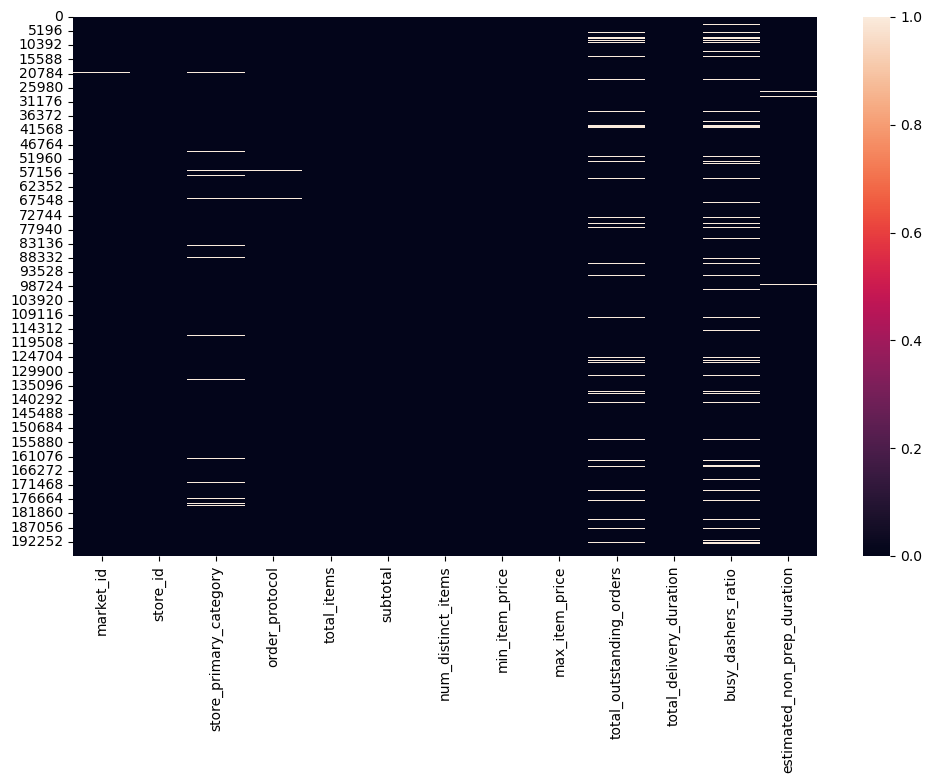

In [208]:
sns.heatmap(df.isna())
plt.show()

In [209]:
df.columns

Index(['market_id', 'store_id', 'store_primary_category', 'order_protocol',
       'total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
       'max_item_price', 'total_outstanding_orders', 'total_delivery_duration',
       'busy_dashers_ratio', 'estimated_non_prep_duration'],
      dtype='object')

In [210]:
num_columns = ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
       'max_item_price',
       'total_outstanding_orders',
       'total_delivery_duration', 'busy_dashers_ratio',
       'estimated_non_prep_duration']

#### A) Univariate

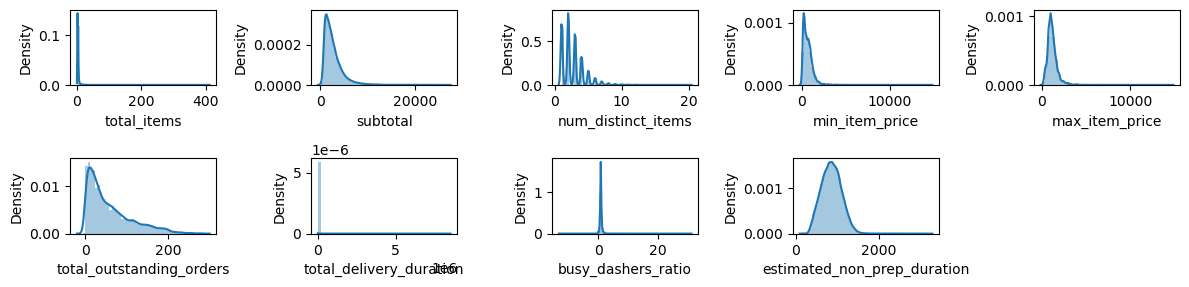

In [211]:
it=1
for i in num_columns:
    plt.subplot(5,5,it)
    sns.distplot(df[i])
    it+=1
plt.tight_layout()
plt.show()

- Most of the columns are Right skewed

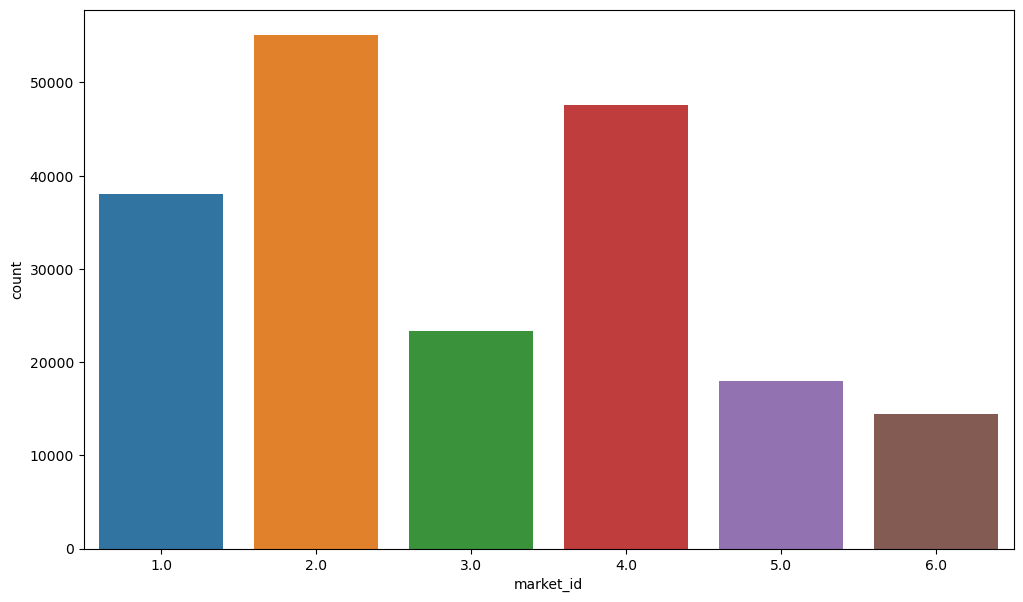

In [212]:
sns.countplot(df['market_id'])
plt.show()

- More orders are coming from the Markets 2,4. There is a good chance they are high end cities.

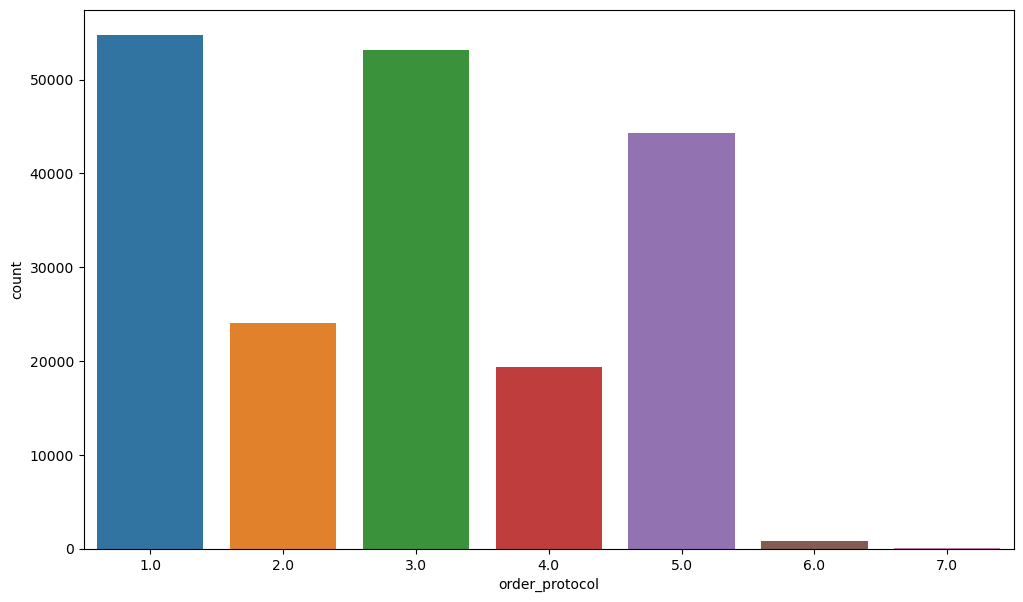

In [213]:
sns.countplot(df['order_protocol'])
plt.show()

- Based on the analysis we can clearly see order protocols 1,3,5 are highly appreciated.

#### B) Bivariate

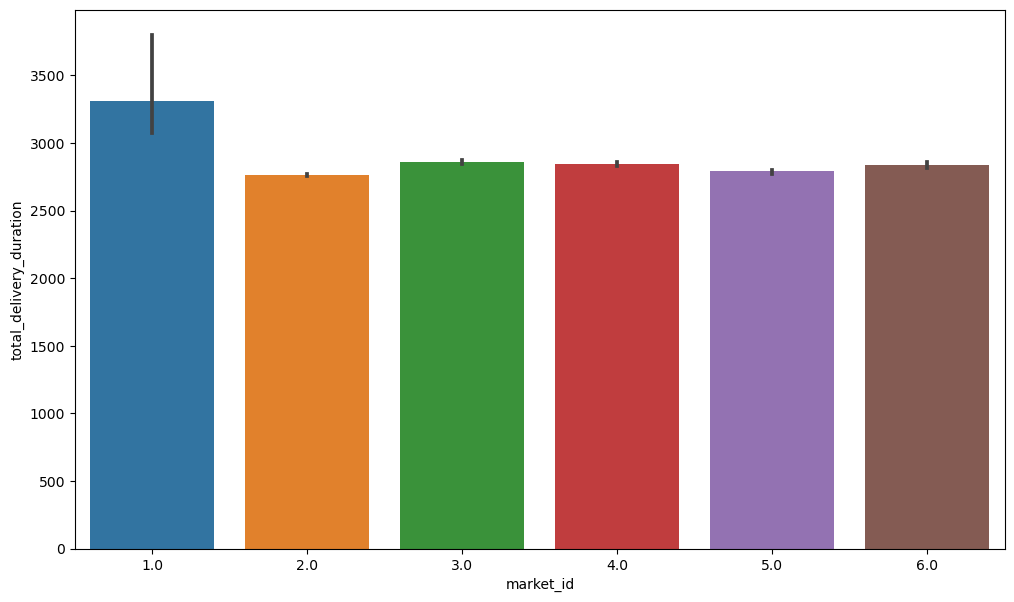

In [214]:
sns.barplot(df['market_id'],df['total_delivery_duration'])
plt.show()

- We can infer that delivery duration is high in market 1. This might be because market 1 is a city and might have a lot of traffic because of this.

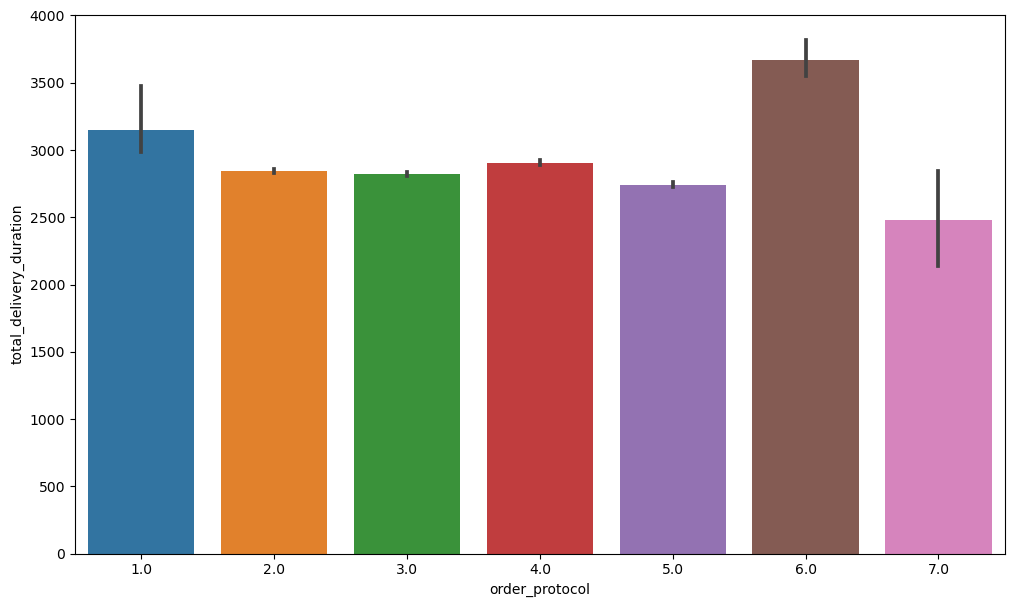

In [215]:
sns.barplot(df['order_protocol'],df['total_delivery_duration'])
plt.show()

- Here we can clearly see the delivery duration is very high for the order protocol 1,6 which is aan interetsing insight.

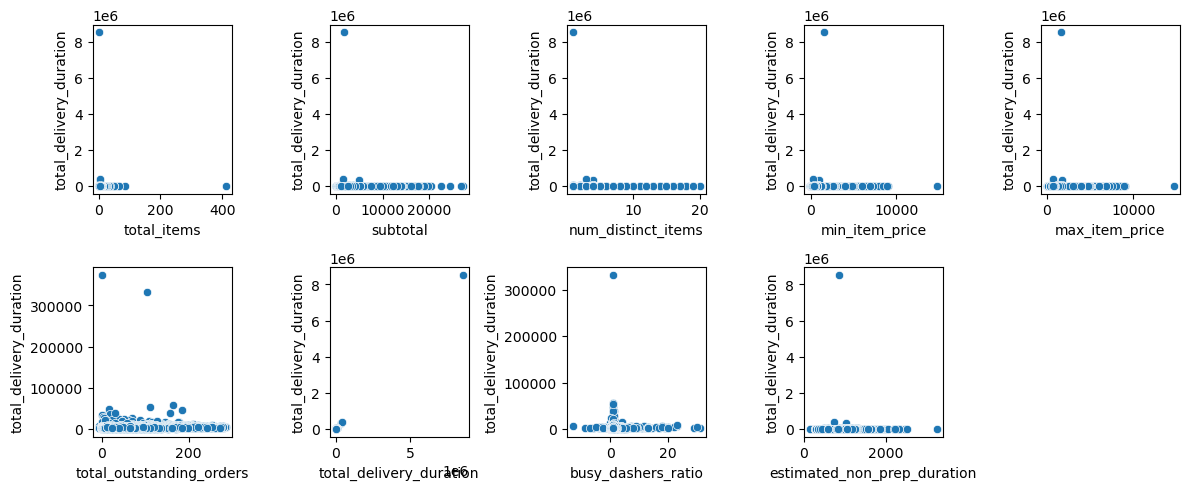

In [216]:
it=1
for i in num_columns:
    plt.subplot(3,5,it)
    sns.scatterplot(df[i],df['total_delivery_duration'])
    it+=1
plt.tight_layout()
plt.show()

- We can see there are few outliers for certain attributes. This needs to checed upon.
- Looks like the data points are not completely scatterd.

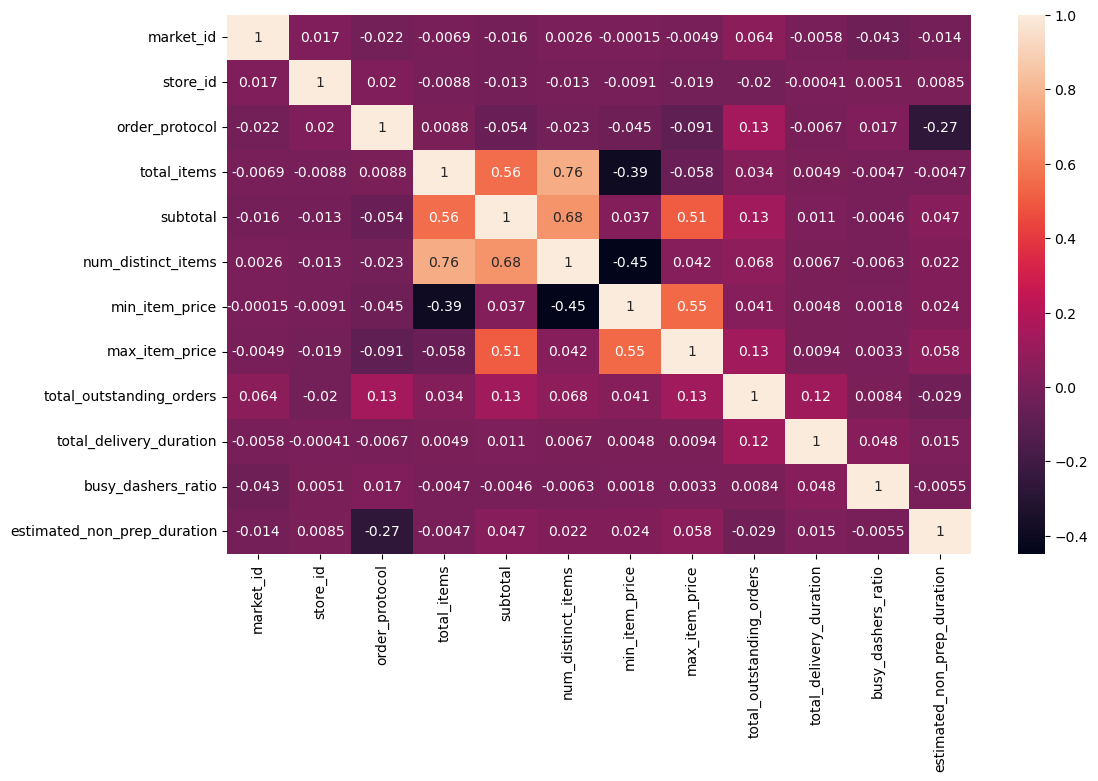

In [217]:
sns.heatmap(df.corr(),annot=True,)
plt.show()

- As we can see a lot of columns are highly corelated. For linear regression it is important that the columns with high corelation are handled/removed. 

# Feature Engineering

In [218]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [219]:
df = df.dropna().reset_index(drop=True)
df.isna().sum()

market_id                      0
store_id                       0
store_primary_category         0
order_protocol                 0
total_items                    0
subtotal                       0
num_distinct_items             0
min_item_price                 0
max_item_price                 0
total_outstanding_orders       0
total_delivery_duration        0
busy_dashers_ratio             0
estimated_non_prep_duration    0
dtype: int64

In [220]:
df = df.sample(n=40000,random_state=47)

### Statistical Analysis

In [221]:
# Creating a dataframe to store the results of statistical results

statistical_result = pd.DataFrame(columns = ['Column','Pvalue','Remarks'])

# Numerical vs Numerical - Pearsonr test

for i in num_columns:
    stat , pval = stats.pearsonr(df[i],df['total_delivery_duration'])
    
    statistical_result = statistical_result.append({'Column':i , 'Pvalue':pval,
                                                   'Remarks':'Reject H0' if pval <= 0.05 else 'Failed to reject H0'},
                                                  ignore_index=True)

In [222]:
cat_columns = ['market_id','store_id','order_protocol','store_primary_category']

In [223]:
df['market_id'] = df['market_id'].astype('str')
df['store_id'] = df['store_id'].astype('str')
df['order_protocol'] = df['order_protocol'].astype('str')
df['store_primary_category'] = df['store_primary_category'].astype('str')

In [224]:
# Numerical vs Categorical - f_oneway test

for i in cat_columns:
    groups =  [df.loc[df[i] == subclass , 'total_delivery_duration'] for subclass 
              in df[i].unique()]
    
    stat , pval = stats.f_oneway(*groups)
    
    statistical_result = statistical_result.append({'Column':i , 'Pvalue':pval,
                                                   'Remarks':'Reject H0' if pval <= 0.05 else 'Failed to reject H0'},
                                                  ignore_index=True)
statistical_result

,Column,Pvalue,Remarks
0,total_items,3.190334e-116,Reject H0
1,subtotal,0.000000e+00,Reject H0
2,num_distinct_items,2.818952e-192,Reject H0
3,min_item_price,2.138697e-02,Reject H0
4,max_item_price,4.130517e-150,Reject H0
5,total_outstanding_orders,0.000000e+00,Reject H0
6,total_delivery_duration,0.000000e+00,Reject H0
7,busy_dashers_ratio,7.396304e-38,Reject H0
8,estimated_non_prep_duration,0.000000e+00,Reject H0
9,market_id,1.315330e-90,Reject H0


- We can infer that all the columns both numerical and categorical are significant features contributing to the target column.

### Train-Test Split

In [225]:
x = df.drop(columns = 'total_delivery_duration')
y = df['total_delivery_duration']

x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.30,random_state=100)

### Encoding

In [226]:
from category_encoders import CatBoostEncoder
for i in cat_columns:
    ct = CatBoostEncoder()
    
    variable = ct.fit(df[i],df['total_delivery_duration'])
    
    x_train[i] = variable.transform(x_train[[i]])
    x_test[i] = variable.transform(x_test[[i]])

# Model Building

### 1) Base model

In [227]:
model_lr = sm.OLS(y_train , sm.add_constant(x_train)).fit()

model_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     total_delivery_duration   R-squared:                       0.305
Model:                                 OLS   Adj. R-squared:                  0.304
Method:                      Least Squares   F-statistic:                     1021.
Date:                     Fri, 06 Oct 2023   Prob (F-statistic):               0.00
Time:                             22:21:11   Log-Likelihood:            -2.3174e+05
No. Observations:                    28000   AIC:                         4.635e+05
Df Residuals:                        27987   BIC:                         4.636e+05
Df Model:                               12                                         
Covariance Type:                 nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -2233.3574    229.476     -9.732      0.000   -2683.141   -1783.574
market_id                       0.7348      0.052     14.148      0.000       0.633       0.837
store_id                        1.0125      0.014     73.907      0.000       0.986       1.039
store_primary_category         -0.2478      0.039     -6.378      0.000      -0.324      -0.172
order_protocol                 -0.1838      0.057     -3.218      0.001      -0.296      -0.072
total_items                    11.7234      4.078      2.874      0.004       3.729      19.717
subtotal                        0.0626      0.006     10.528      0.000       0.051       0.074
num_distinct_items              7.8893      7.339      1.075      0.282      -6.495      22.273
min_item_price                 -0.0280      0.016     -1.725      0.085      -0.060       0.004
max_item_price                 -0.0593      0.016     -3.774      0.000      -0.090      -0.029
total_outstanding_orders        4.4282      0.117     38.006      0.000       4.200       4.657
busy_dashers_ratio            159.1728     14.097     11.291      0.000     131.542     186.804
estimated_non_prep_duration     0.9278      0.026     36.105      0.000       0.877       0.978
==============================================================================
Omnibus:                    34716.340   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         57348989.073
Skew:                           5.858   Prob(JB):                         0.00
Kurtosis:                     224.402   Cond. No.                     2.65e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [228]:
from sklearn.metrics import r2_score

pred_train = model_lr.predict(sm.add_constant(x_train))
pred_test = model_lr.predict(sm.add_constant(x_test))

rmse_train = np.sqrt(mean_squared_error(y_train , pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test , pred_test))

print('RMSE Train',rmse_train)
print('RMSE Test',rmse_test)

RMSE Train 950.8683065201046
RMSE Test 922.5044268653264


### 2) RFE Model

In [229]:
from sklearn.feature_selection import RFE
# initiate linear regression model to use in feature selection
linreg_rfe = LinearRegression()

# build the RFE model
# pass the regression model to 'estimator'
# pass number of required features to 'n_features_to_select'
# if we do not pass the number of features, RFE considers half of the features
rfe_model = RFE(estimator=linreg_rfe, n_features_to_select = 5)

# fit the RFE model on the training dataset using fit()
# we use the independent variables including intersection variable 'T_out*RH_out'
rfe_model = rfe_model.fit(x_train, y_train)

# create a series containing feature and its corresponding rank obtained from RFE
# 'ranking_' returns the rank of each variable after applying RFE
# pass the ranks as the 'data' of a series
# 'index' assigns feature names as index of a series 
feat_index = pd.Series(data = rfe_model.ranking_, index = x_train.columns)

# select the features with rank = 1
# 'index' returns the indices of a series (i.e. features with rank=1) 
signi_feat_rfe = feat_index[feat_index==1].index

# print the significant features obtained from RFE
print(signi_feat_rfe)

Index(['store_id', 'total_items', 'num_distinct_items',
       'total_outstanding_orders', 'busy_dashers_ratio'],
      dtype='object')


In [230]:
# store the X_train with significant variables in new_X_train
new_x_train = x_train[signi_feat_rfe]

# initiate linear regression
linreg = LinearRegression()

# build the model using new_X_train and y_train
linreg.fit(new_x_train, y_train)

# check the score
linreg.score(new_x_train, y_train)

0.26304257399594255

### 3) VIF

In [231]:
def compute_vif (features):

    """Compute VIF score using variance_inflation_factor() function"""

    vif_data = pd.DataFrame()

    vif_data["feature"] = features

    vif_data["VIF"] = [variance_inflation_factor (x_train [features].values, i) for i in range(len(features))] 
    
    return vif_data.sort_values (by=['VIF']).reset_index(drop=True)

In [232]:
num_columns

['total_items',
 'subtotal',
 'num_distinct_items',
 'min_item_price',
 'max_item_price',
 'total_outstanding_orders',
 'total_delivery_duration',
 'busy_dashers_ratio',
 'estimated_non_prep_duration']

In [233]:
num_columns.remove('total_delivery_duration')

In [234]:
# apply VIF computation to all columns

features = x_train[num_columns].columns.to_list()

vif_data = compute_vif (features)

vif_data

,feature,VIF
0,total_outstanding_orders,2.270138
1,busy_dashers_ratio,5.368194
2,min_item_price,5.406862
3,total_items,8.319840
4,estimated_non_prep_duration,8.451056
5,subtotal,10.453932
6,max_item_price,11.777647
7,num_distinct_items,14.841663


### 4) RandomForestRegressor

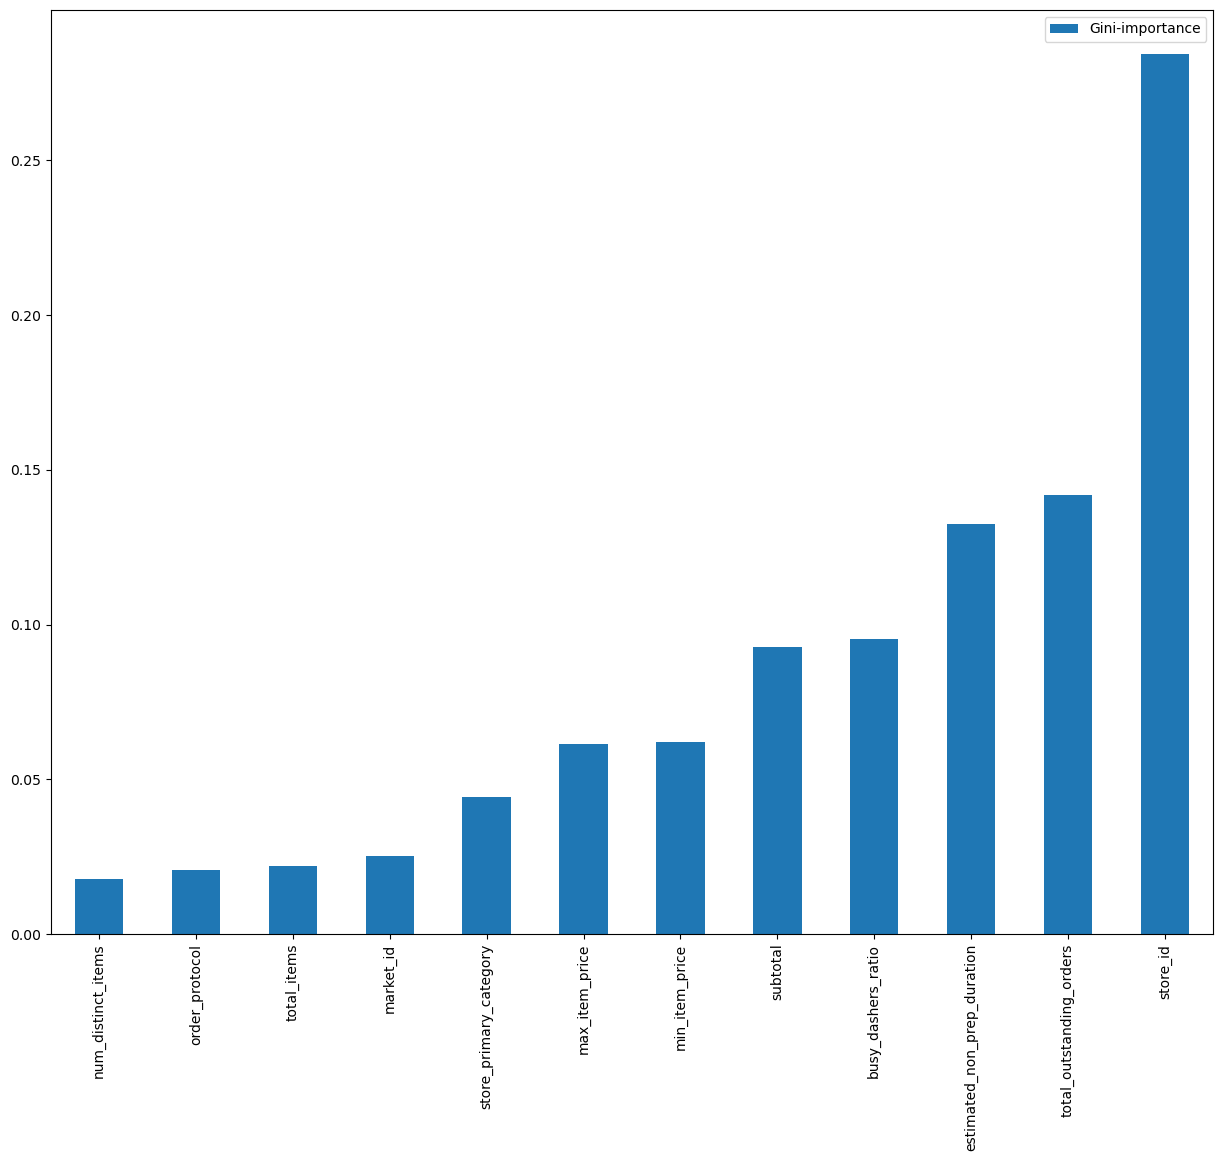

In [235]:
from sklearn.ensemble import RandomForestRegressor

feature_names= [f"feature{i}" for i in range((x.shape[1]))] 
forest = RandomForestRegressor(random_state=42)

forest.fit(x_train, y_train)

feats = {} # a dict to hold feature_name: feature_importance

for feature, importance in zip(x.columns, forest. feature_importances_): 
    feats [feature] = importance 

#add the name/value pair
importances = pd.DataFrame.from_dict (feats, orient='index').rename(columns={0: 'Gini-importance'}) 
importances.sort_values (by= 'Gini-importance').plot(kind= "bar", rot=90, figsize=(15,12)) 
plt.show()

### 5) PCA

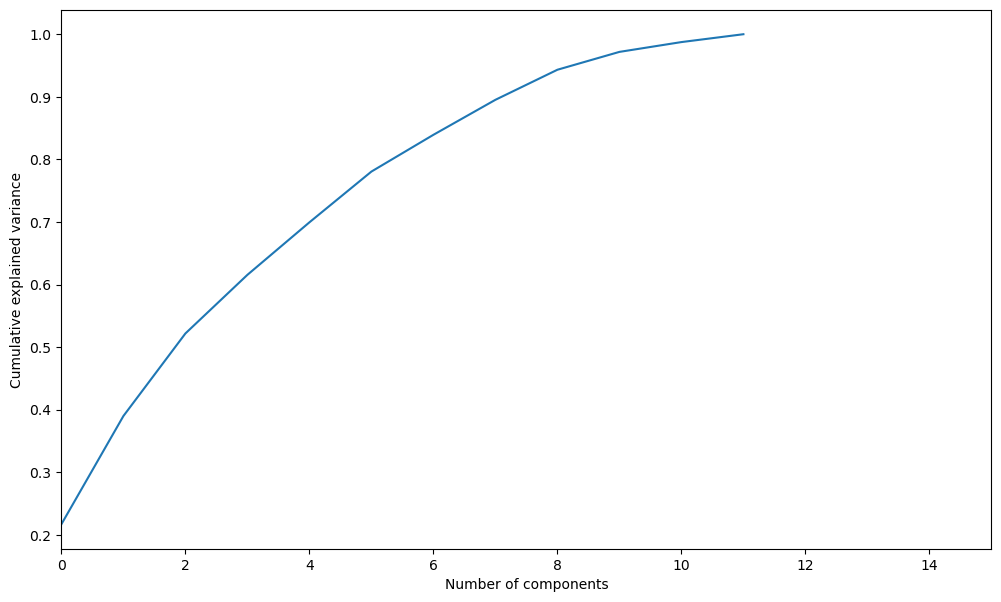

In [236]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_Train= np.asarray(x_train.values)
#Finding normalised array of X_Train
X_std= StandardScaler().fit_transform(x_train)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,15,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance') 
plt.show()


### 6) Multiple models

In [237]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [238]:
def scale(scaler, x_train,x_test,y_train, y_test):

    """Apply the selected scaler to features and target variables"""

    X_scaler = scaler
    
    X_scaler.fit(X=x_train, y=y_train)
    
    X_train_scaled = X_scaler.transform(x_train)
    
    X_scaler.fit(X=x_test, y=y_test)
    
    X_test_scaled = X_scaler.transform(x_test)
    
    ###########################################
    
    y_scaler = scaler

    y_scaler.fit(y_train.values.reshape(-1, 1))

    y_train_scaled = y_scaler.transform(y_train.values.reshape(-1, 1))
    
    y_scaler.fit(y_test.values.reshape(-1, 1))

    y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

    return X_train_scaled,X_test_scaled, y_train_scaled, y_test_scaled, X_scaler, y_scaler

In [239]:
x_train.columns

Index(['market_id', 'store_id', 'store_primary_category', 'order_protocol',
       'total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
       'max_item_price', 'total_outstanding_orders', 'busy_dashers_ratio',
       'estimated_non_prep_duration'],
      dtype='object')

In [240]:
def rmse_with_inv_transform(scaler,y_test,y_pred_scaled,model_name):
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1,1))
    rmse_error = mean_squared_error(y_test,y_predict[:,0],squared=False)
    print("Error : {}".format(rmse_error)+" in "+model_name)
    return rmse_error,y_predict

In [241]:
#create a generic function which can work with multiple machine learning models

def make_regression (x_train, y_train, x_test, y_test, model, model_name, verbose=True):
    """Apply selected regression model to data and measure error"""

    model.fit(x_train,y_train) 
    y_predict = model.predict(x_train)

    train_error = mean_squared_error(y_train, y_predict, squared=False) 
    y_predict = model.predict(x_test)

    test_error = mean_squared_error(y_test, y_predict, squared=False) 
    if verbose:

        print("Train error = "'{}'.format(train_error) +" in "+ model_name) 
        print("Test error = "'{}'.format(test_error)+" in "+ model_name)

    trained_model = model

    return trained_model, y_predict, train_error, test_error

In [242]:
pred_dict = {"regression_model": [],
"feature_set": [],
"scaler_name": [],
"RMSE": []
}

regression_models = {"Ridge" : linear_model.Ridge(),
"DecisionTree": tree.DecisionTreeRegressor(max_depth=6),
"RandomForest": RandomForestRegressor(), 
"XGBoost": XGBRegressor(),
"LGBM": LGBMRegressor(force_col_wise= True)
}

feature_sets = {"full_dataset": x.columns.to_list(),
"selected features_8": importances.sort_values(by ="Gini-importance")[-8:].index.to_list()
}
                                                
scalers = {"NoScaling": None,
"Standard scaler": StandardScaler(),
"MinMax scaler": MinMaxScaler(), 
}

In [243]:
import logging

# Set the logging level to WARNING to suppress informational messages
logging.getLogger('lightgbm').setLevel(logging.WARNING)

In [244]:
for feature_set_name in feature_sets.keys(): 
    feature_set = feature_sets[feature_set_name]

    for scaler_name in scalers.keys(): 
        print(f"-----------------scaled with {scaler_name} ------------included columns are {feature_set_name}") 
        print("")

        for model_name in regression_models.keys():

            if scaler_name == "NoScaling":
                print(model_name)
                make_regression(x_train, y_train, x_test, y_test,regression_models[model_name], model_name, verbose=True)
                y_predict = regression_models[model_name].predict(x_test)
                rmse_error = mean_squared_error(y_test,y_predict,squared=False)
            else:
                X_train_scaled,X_test_scaled, y_train_scaled, y_test_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], x_train[feature_set],x_test[feature_set], y_train,y_test)
                _,y_predict_scaled,_,_ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled,regression_models[model_name],model_name,verbose=False)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
             
            pred_dict["regression_model"].append(model_name) 
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)
         #   print(f"Added entry to pred_dict - Feature Set: {feature_set_name}, Scaler: {scaler_name}, Model: {model_name}, RMSE: {rmse_error}")
           # print("")

-----------------scaled with NoScaling ------------included columns are full_dataset

Ridge
Train error = 950.8683066246905 in Ridge
Test error = 922.5044313449639 in Ridge
DecisionTree
Train error = 910.4027528176798 in DecisionTree
Test error = 958.5144582888422 in DecisionTree
RandomForest
Train error = 363.90050893612704 in RandomForest
Test error = 937.5214598675694 in RandomForest
XGBoost
Train error = 694.9908114415516 in XGBoost
Test error = 936.9345502852981 in XGBoost
LGBM
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 12
[LightGBM] [Info] Start training from score 2849.286143
Train error = 844.7808231599756 in LGBM
Test error = 909.9488260022298 in LGBM
-----------------scaled with Standard scaler ------------included columns are full_dataset

Error : 922.423572185145 in Ridge
Error : 958.1406751802475 in DecisionTree
Error : 935.3395187336073 in RandomForest
Error : 944.7121137098154 in XGBoost
[Li

In [245]:
for i in pred_dict:
    print(len(pred_dict[i]))

30
30
30
30


In [246]:
df_error = pd.DataFrame(pred_dict).sort_values(by='RMSE').reset_index(drop='first')
df_error

,regression_model,feature_set,scaler_name,RMSE
0,LGBM,selected features_8,NoScaling,909.948826
1,LGBM,full_dataset,NoScaling,909.948826
2,LGBM,full_dataset,Standard scaler,910.788968
3,LGBM,selected features_8,Standard scaler,921.889157
4,Ridge,full_dataset,Standard scaler,922.423572
5,Ridge,full_dataset,NoScaling,922.504431
6,Ridge,selected features_8,NoScaling,922.504431
7,Ridge,selected features_8,Standard scaler,925.876795
8,RandomForest,full_dataset,Standard scaler,935.339519
9,XGBoost,full_dataset,NoScaling,936.934550


In [247]:
df_least_error_models = df_error[(df_error['feature_set']=='full_dataset') & (df_error['RMSE']<950)].reset_index(drop='first')
df_least_error_models

,regression_model,feature_set,scaler_name,RMSE
0,LGBM,full_dataset,NoScaling,909.948826
1,LGBM,full_dataset,Standard scaler,910.788968
2,Ridge,full_dataset,Standard scaler,922.423572
3,Ridge,full_dataset,NoScaling,922.504431
4,RandomForest,full_dataset,Standard scaler,935.339519
5,XGBoost,full_dataset,NoScaling,936.934550
6,RandomForest,full_dataset,NoScaling,937.521460
7,XGBoost,full_dataset,Standard scaler,944.712114


In [248]:
x = df.drop(columns = 'total_delivery_duration')
y = df['total_delivery_duration']

x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.30,random_state=100)

In [249]:
from category_encoders import CatBoostEncoder
for i in cat_columns:
    ct = CatBoostEncoder()
    
    variable = ct.fit(df[i],df['total_delivery_duration'])
    
    x_train[i] = variable.transform(x_train[[i]])
    x_test[i] = variable.transform(x_test[[i]])

In [250]:
import lightgbm as lgb

In [251]:
# Create a LightGBM regressor
lgb_regressor = lgb.LGBMRegressor()

# Define hyperparameters and their potential values for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'num_leaves': [2,5,10]
}

# Create the grid search with cross-validation
grid_search = GridSearchCV(estimator=lgb_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0)

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Create a new LightGBM regressor with the best hyperparameters
best_lgb_regressor = lgb.LGBMRegressor(**best_params)

# Fit the best model to the training data
best_lgb_regressor.fit(x_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_lgb_regressor.predict(x_train)
y_test_pred = best_lgb_regressor.predict(x_test)

# Calculate the training and testing RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Print the training and testing RMSE
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}")

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1903
[LightGBM] [Info] Number of data points in the train set: 18666, number of used features: 12
[LightGBM] [Info] Start training from score 2845.381924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Start training from score 2847.494455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Sta

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Start training from score 2847.494455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Start training from score 2854.981840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1903
[LightGBM] [Info] Number of data points in the train set: 18666, number of used features: 12
[LightGBM] [Info] Sta

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1903
[LightGBM] [Info] Number of data points in the train set: 18666, number of used features: 12
[LightGBM] [Info] Start training from score 2845.381924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Start training from score 2847.494455
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the tra

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1903
[LightGBM] [Info] Number of data points in the train set: 18666, number of used features: 12
[LightGBM] [Info] Start training from score 2845.381924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Start training from score 2847.494455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Sta

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1903
[LightGBM] [Info] Number of data points in the train set: 18666, number of used features: 12
[LightGBM] [Info] Start training from score 2845.381924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Start training from score 2847.494455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Sta

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Start training fro

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Start training from score 2847.494455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1903
[LightGBM] [Info] Number of data points in the train set: 18666, number of used features: 12
[LightGBM] [Info] Start training from score 2845.381924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1906
[LightGBM

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Start training from score 2854.981840
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1903
[LightGBM] [Info] Number of data points in the train set: 18666, number of used features: 12
[LightGBM] [Info] Start training from score 2845.381924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Start training from score 2847.494455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the tra

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Start training from score 2854.981840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1903
[LightGBM] [Info] Number of data points in the train set: 18666, number of used features: 12
[LightGBM] [Info] Start training from score 2845.381924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Sta

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Start training from score 2847.494455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Start training from score 2854.981840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1903
[LightGBM] [Info] Number of data points in the train set: 18666, number of used features: 12
[LightGBM] [Info] Sta

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Start training from score 2854.981840
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1903
[LightGBM] [Info] Number of data points in the train set: 18666, number of used features: 12
[LightGBM] [Info] Start training from score 2845.381924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Start training from score 2847.494455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Sta

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Start training from score 2847.494455
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Start training from score 2854.981840
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1903
[LightGBM] [Info] Number of data points in the train set: 18666, number of used features: 12
[LightGBM] [Info] Start training from score 2845.381924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Start training from score 2847.494455
[LightGBM]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Start training from score 2847.494455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1903
[LightGBM] [Info] Number of data points in the train set: 18666, number of used features: 12
[LightGBM] [Info] Start training from score 2845.381924
[LightGBM] [Info] Auto-choosing col-wise multi-threadin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1903
[LightGBM] [Info] Number of data points in the train set: 18666, number of used features: 12
[LightGBM] [Info] Start training from score 2845.381924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Start training from score 2847.494455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Sta

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the train set: 18667, number of used features: 12
[LightGBM] [Info] Start training from score 2854.981840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1903
[LightGBM] [Info] Number of data points in the train set: 18666, number of used features: 12
[LightGBM] [Info] Start training from score 2845.381924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points

In [252]:
# Print the training and testing RMSE
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}")

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

Training RMSE: 898.2791
Testing RMSE: 909.7186
Best Hyperparameters:
{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 10}


In [254]:
# Create an XGBoost regressor
xgb_regressor = XGBRegressor()

# Define hyperparameters and their potential values for grid search
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
}

# Create the grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0)

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

In [255]:
# Create a new XGBoost regressor with the best hyperparameters
best_xgb_regressor = XGBRegressor(**best_params)

# Fit the best model to the training data
best_xgb_regressor.fit(x_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_xgb_regressor.predict(x_train)
y_test_pred = best_xgb_regressor.predict(x_test)

# Calculate the training and testing RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

In [256]:
# Print the training and testing RMSE
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}")

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

Training RMSE: 825.8531
Testing RMSE: 915.8799
Best Hyperparameters:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}


In [257]:
ss =StandardScaler()

for i in num_columns :
    variable = ss.fit(x_train[[i]])
    
    x_train[i] = variable.transform(x_train[[i]])
    x_test[i] = variable.transform(x_test[[i]])

In [258]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Create a RandomForestRegressor model
rf_regressor = RandomForestRegressor(random_state=42)

# Define hyperparameters and their potential values for grid search
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create the grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Create a new RandomForestRegressor with the best hyperparameters
best_rf_regressor = RandomForestRegressor(random_state=42, **best_params)

# Fit the best model to the training data
best_rf_regressor.fit(x_train, y_train)

# Make predictions on the training and test data
y_train_pred = best_rf_regressor.predict(x_train)
y_test_pred = best_rf_regressor.predict(x_test)

# Calculate training and test RMSE
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# Print the RMSE values
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Training RMSE: 710.2636900803491
Test RMSE: 918.6280008865427
Best Hyperparameters:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [259]:
best_params_rf_cv = {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

In [260]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Create base regressors
base_regressors = [
    ('LGBM', lgb.LGBMRegressor(random_state=42,force_col_wise= True, learning_rate= 0.05, max_depth= 5, n_estimators= 200, num_leaves= 10)),
    ('XGBResgressor', XGBRegressor(random_state=42,learning_rate= 0.1, max_depth= 5, n_estimators = 100))
]

# Create the stacking regressor with a meta-regressor (e.g., Linear Regression)
stacking_regressor = StackingRegressor(estimators=base_regressors, 
                                       final_estimator=lgb.LGBMRegressor(random_state=42,force_col_wise= True, 
                                                                         learning_rate= 0.05, max_depth= 5, n_estimators= 200, num_leaves= 10))

# Fit the stacking regressor on the training data
stacking_regressor.fit(x_train, y_train)

# Make predictions on the test data
y_pred = stacking_regressor.predict(x_test)

# Evaluate the stacking regressor using Mean Squared Error (MSE)
rmse = mean_squared_error(y_test, y_pred,squared=False)
print(f"Root Mean Squared Error: {rmse}")


[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 12
[LightGBM] [Info] Start training from score 2849.286143
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 22400, number of used features: 12
[LightGBM] [Info] Start training from score 2843.392589
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points in the train set: 22400, number of used features: 12
[LightGBM] [Info] Start training from score 2854.628661
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 22400, number of used features: 12
[LightGBM] [Info] Start training from score 2847.124688
[LightGBM] [Info] Total Bins 1907
[LightGBM] [Info] Number of data points in the train set: 22400, number of used features: 12
[LightGBM] [Info] Start training from score 2849.258214
[LightGBM] [Info] Total Bins 1905
[LightGBM] [Info] Number of data points in the trai

<h1>Conclusion: DoorDash Delivery Duration Prediction</h1>

<p><strong>Data Preparation:</strong> The initial data preprocessing involved converting timestamps, calculating delivery duration, and creating relevant features. Handling missing values and outliers was essential for ensuring data quality.</p>

<p><strong>Feature Engineering:</strong> Multiple feature engineering techniques were applied, including the creation of new features like 'busy_dashers_ratio' and 'estimated_non_prep_duration.' Feature selection methods, such as statistical tests and feature importance, were employed to identify the most significant predictors.</p>

<p><strong>Model Selection:</strong> A wide range of regression models was evaluated, including Linear Regression, Ridge Regression, Decision Trees, Random Forest, XGBoost, and LightGBM. Different combinations of features and scaling techniques were tested to find the best-performing models.</p>

<p><strong>Hyperparameter Tuning:</strong> GridSearchCV was used to optimize hyperparameters for the LightGBM model. This allowed for fine-tuning and improved model performance.</p>

<p><strong>Stacking Model:</strong> A stacking ensemble model was constructed by combining LightGBM and XGBoost as base regressors and LightGBM as the final estimator. Stacking models can often provide enhanced predictive accuracy.</p>

<p><strong>Evaluation:</strong> The models were evaluated using Root Mean Squared Error (RMSE) on both the training and testing datasets. RMSE is a suitable metric for assessing the accuracy of delivery duration predictions.</p>

<p><strong>Conclusion:</strong> After thorough evaluation, it was determined that the LightGBM model, with hyperparameter tuning, emerged as the best-performing model for predicting delivery durations accurately. This model, along with its optimized hyperparameters, provides DoorDash with a robust tool for estimating delivery times and enhancing the overall customer experience.</p>
